# Degit Recogniser

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


## Import data as Images  

In [2]:
dTrain = pd.read_csv('./data/train.csv')
dTest = pd.read_csv('./data/test.csv')
X = dTrain.iloc[:,1:]
y = dTrain.iloc[:,0]
Xtest = dTest

In [3]:
# Reshape the rows to matrices of dim 28*28 
X = X.values.reshape(X.shape[0],28,28)
Xtest = Xtest.values.reshape(Xtest.shape[0],28,28)

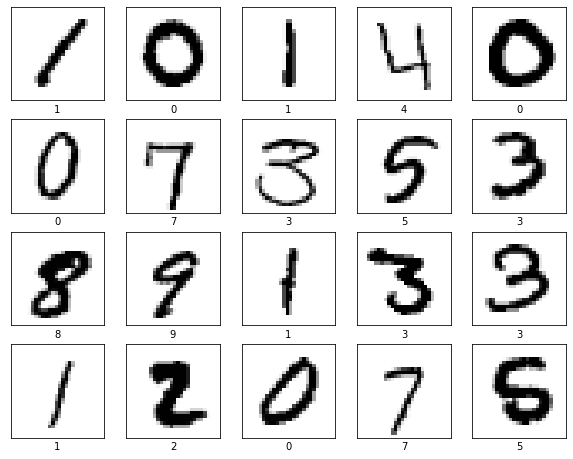

In [4]:
#Read few images after reshape 
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(y[i])
plt.show()

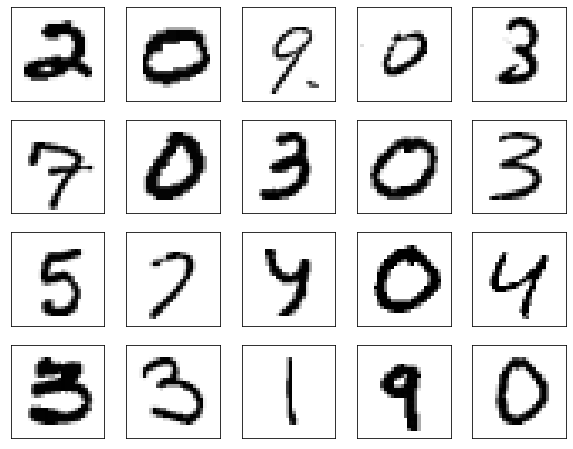

In [5]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(Xtest[i], cmap=plt.cm.binary)
plt.show()

## Split train and test

In [6]:
# One hot encoding
y = to_categorical(y, num_classes=10)

In [7]:
X = X.reshape(-1,28,28,1)
Xtest = Xtest.reshape(-1,28,28,1)

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

## Data augmentation

In [22]:
data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=1,
                                    zoom_range=0.1, 
                                    width_shift_range=0.05,
                                    height_shift_range=0.05)
data_generator.fit(X_train)

## Building the CNN

In [23]:
#Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 : Convolution 
cnn.add(tf.keras.layers.Conv2D(filters= 32,kernel_size=(5,5),activation='relu',input_shape=(28, 28, 1)))
cnn.add(tf.keras.layers.Conv2D(filters= 32,kernel_size=(5,5),activation='relu'))
# Step 1 : Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
cnn.add(tf.keras.layers.Dropout(0.5))


# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters= 64,kernel_size=(3,3),activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters= 64,kernel_size=(3,3),activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
cnn.add(tf.keras.layers.Dropout(0.5))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(8192, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))

cnn.add(tf.keras.layers.Dense(2048, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))


# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=10,
                              activation='softmax'))

## Training the model 

In [24]:
# Compile CNN
cnn.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001,rho=0.9,epsilon=1e-08,decay=0.00001),
            loss="categorical_crossentropy",
            metrics=["accuracy"])

In [25]:
print(cnn.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 64)         

In [26]:
# Training the CNN on the Training set and evaluating it on the Test set¶
cnn.fit(data_generator.flow(X_train,y_train,batch_size=512),
        validation_data=(X_test, y_test),
        epochs=100,
        )   
print(cnn.summary())

Epoch 1/100
66/66 [==============================] - 255s 4s/step - loss: 1.5670 - accuracy: 0.4665 - val_loss: 51.3709 - val_accuracy: 0.8245
Epoch 2/100
66/66 [==============================] - 304s 5s/step - loss: 0.8324 - accuracy: 0.7271 - val_loss: 29.7744 - val_accuracy: 0.9133
Epoch 3/100
66/66 [==============================] - 361s 5s/step - loss: 0.5497 - accuracy: 0.8258 - val_loss: 28.7708 - val_accuracy: 0.9251
Epoch 4/100
66/66 [==============================] - 269s 4s/step - loss: 0.4076 - accuracy: 0.8711 - val_loss: 20.8126 - val_accuracy: 0.9507
Epoch 5/100
66/66 [==============================] - 153s 2s/step - loss: 0.3318 - accuracy: 0.8953 - val_loss: 21.1281 - val_accuracy: 0.9565
Epoch 6/100
66/66 [==============================] - 132s 2s/step - loss: 0.2737 - accuracy: 0.9156 - val_loss: 15.5370 - val_accuracy: 0.9690
Epoch 7/100
66/66 [==============================] - 233s 4s/step - loss: 0.2406 - accuracy: 0.9252 - val_loss: 13.3961 - val_accuracy: 0.9705

## Prepare submission

In [27]:
#cnn.fit(data_generator.flow(X,y), epochs = 100)
y_pred = cnn.predict_classes(Xtest)
#Preparing Submission
submission = pd.DataFrame({'Label':y_pred})
submission.insert(0, 'ImageId', range(1, 1 + len(submission)))
submission.to_csv('./data/DegitRecogniser_CNN004.csv',index=False)